# Tree-Based Methods & Ensembling Techniques (Notebook Development In Progress...)

## Intro

<br /><br />

### Motivation

Most of the models we've learned so far (linear/logistic regression, svm) and models we will learn in the upcoming classes (neural networks) involve <b>gradient-based weight optimization (using SGD).</b>

In this class we will go through tree-based models, known as decision trees, that are different in a sense that they <b>do not require</b> weight optimization via SGD. Besides, tree-based models are <b>nonlinear</b>.

Besides, we will learn about model ensembling - powerful technique in ML of combining multiple models in different ways in order to get much powerful models. Particularly, we will examine two most popular and widely used ways of decision tree ensembling - <b>Random Forests</b> and <b>Gradient Boosting</b>.

As usual, there will be accompanying examples in Scikit-Learn.


### Learning Objectives

At the end of this class, listeners will be able to:

<ul>
    <li>Understand key concepts of decision trees and their ensembles.</li>
    <li>Understand intuition behind different types of model ensembling.</li>
    <li>Implement simple models using Scikit-Learn and Python.</li>
</ul>

### Reading Material (ordered by difficulty)

Decision Trees (for Classification and Regression)

<ul>
    <li>https://www.youtube.com/watch?v=GZuweldJWrM&list=PLnZuxOufsXnvftwTB1HL6mel1V32w0ThI&index=20 - Bloomberg's ML lecture explaining decision trees for classification and regression. (<b>recommended prerequisite for this class</b>)</li>
    <li>https://scikit-learn.org/stable/modules/tree.html - Good explanation of Tree methods with Cons and Pros and practical tips</li>
    <li>T. Hastie, R. Tibshirani and J. Friedman -  Elements of Statistical Learning, SECTION 9.2 - In-depth explanation of theory behind classification/regression trees.</li>
</ul>

Ensembling

<ul>
    <li>
        https://www.youtube.com/watch?v=f2S4hVs-ESw&list=PLqIj-nyfGu55TQpzjv_kwZcz3pJSW9bnH&index=22 - Bloomberg's ML lecture explaining tree ensembles. (<b>recommended prerequisite for this class</b>)
    </li>
    <li>http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/</li>
    <li>https://bloomberg.github.io/foml/#lectures Bloomberg's ML course page (gradient boosting section)</li>
    <li>https://statweb.stanford.edu/~jhf/ftp/trebst.pdf - In-depth theory of Gradient Boosting (Advanced)</li>
</ul>

<br /><br />

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_boston

%matplotlib inline

For the first part of this class we gonna use toy dataset that comes with Scikit-Learn library. The dataset is about predicting house prices in Boston using 13 continuous features: https://scikit-learn.org/stable/datasets/index.html

These are the features of the data:

CRIM - per capita crime rate by town

ZN - proportion of residential land zoned for lots over 25,000 sq.ft.

INDUS - proportion of non-retail business acres per town

CHAS - Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)

NOX - nitric oxides concentration (parts per 10 million)

RM - average number of rooms per dwelling

AGE - proportion of owner-occupied units built prior to 1940

DIS - weighted distances to five Boston employment centres

RAD - index of accessibility to radial highways

TAX - full-value property-tax rate per $10,000

PTRATIO - pupil-teacher ratio by town

B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town

LSTAT - % lower status of the population

TARGET (value we need to estimate) - Median value of owner-occupied homes in $1000’s

Let's now load the data and do some EDA (Exploratory Data Analysis)

In [2]:
# loading the data
X, y = load_boston(return_X_y=True)

# feature names
cols = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

# creating the dataframe for better visualizations and data processing
df = pd.DataFrame(np.c_[X, y], columns=cols + ['TARGET']); df.shape

(506, 14)

In [3]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Let's visualize distribution of each feature using boxplot

We can see that feature scale highly differs, but, fortunately, tree-based models <b>doesn't require</b> feature re-scaling (subtract mean and divide by standard deviation or something similar)

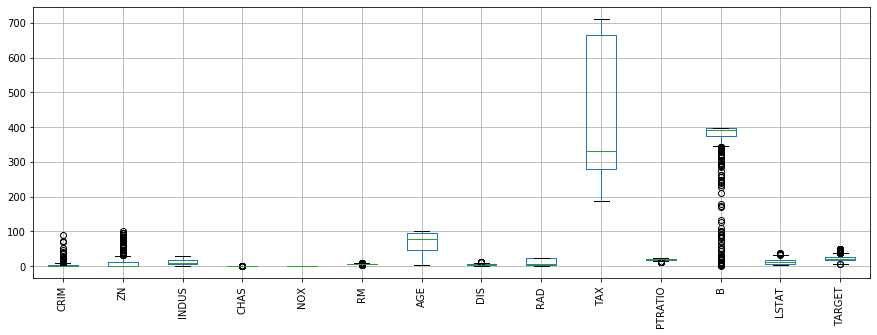

In [4]:
df.plot(kind='box', rot=90, figsize=(15, 5))
plt.grid()

Now let's see correlation (Pearson's correlation) matrix of features and target. 
We can observe that some of the features (e.g LSTAT, RM) are in <b>high correlation</b> with the target, that usually means that they are <b>good predictors</b> for estimating target

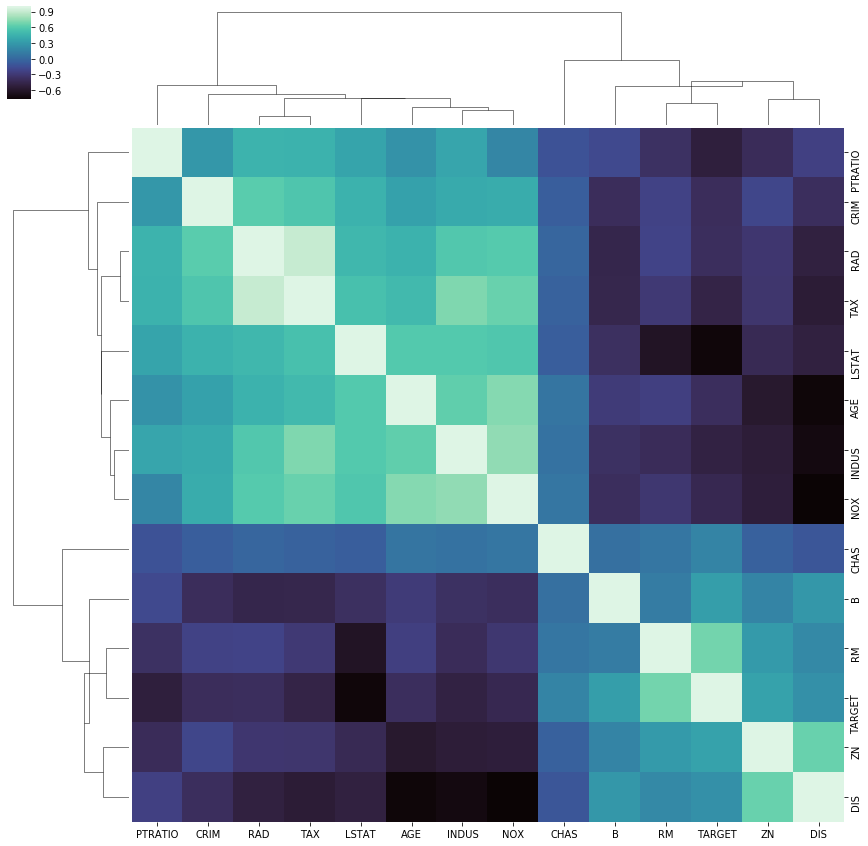

In [5]:
corr = df.corr()
sns.clustermap(corr, figsize=(15, 15), cmap='mako', method='centroid')

In [6]:
# here we sort features in decreasing order of high correlation with target variable.

np.abs(corr['TARGET']).sort_values(ascending=False)

TARGET     1.000000
LSTAT      0.737663
RM         0.695360
PTRATIO    0.507787
INDUS      0.483725
TAX        0.468536
NOX        0.427321
CRIM       0.388305
RAD        0.381626
AGE        0.376955
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
Name: TARGET, dtype: float64

Now lets move on prediction.

Let's imagine our goal is to optimize MSE (Mean Squred Error).

In that case, trivial solution using constant predictor (always predicting same value irrespective of the input) would be the <b>sample mean</b> of targets in training dataset. One can proof mathematically, that for MSE the optimal constant predictor is indeed a mean. You can google it up :)

Let's find out what the MSE is in this case (for simplicity we don't split the data and do everything on training set for now)

In [7]:
def mse(x, y):
    return np.mean((y - x) ** 2)

constant_predictor = df['TARGET'].mean()

mse(constant_predictor, df['TARGET'])

84.4195561561656

We can see empirically that deviations from optimal constant predictor causes MSE to grow, i.e MSE is optimal.

In [8]:
eps = 1

mse(constant_predictor - eps, df['TARGET']), mse(constant_predictor + eps, df['TARGET'])

(85.41955615616551, 85.41955615616557)

Ok, now let's try to do slightly better. 

Let's try to divide our training set in <b>two groups</b> and for each group, calculate <b>their own mean</b>. If we make this split in a smart way, intuitively the two means would be better than using just <b>single global mean</b> as we did in previous example.

One way to do a split is to select on of the features of the data, let's say X, and some threshold, T, and make:<br /><br />
group 1 - {all points having $X<T$}<br />
group 2 - {all points having $X>=T$}<br />

Then we will have 2 constant predictors - one for each group - and, for every input we first gonna determine its group, and then use group's mean to estimate the target.

This intuition is captured by Decision Tree with depth 1.

In [9]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

[Text(167.4, 163.07999999999998, 'RM <= 6.941\nmse = 84.42\nsamples = 100.0%\nvalue = 22.533'),
 Text(83.7, 54.360000000000014, 'mse = 40.273\nsamples = 85.0%\nvalue = 19.934'),
 Text(251.10000000000002, 54.360000000000014, 'mse = 79.729\nsamples = 15.0%\nvalue = 37.238')]

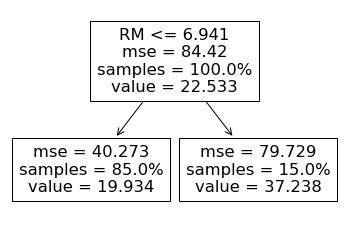

In [10]:
# defining decision tree with depth 1.
dt = DecisionTreeRegressor(max_depth=1)

# fitting the decision tree on our data/
model = dt.fit(X, y)

# visualizing the tree
plot_tree(model, feature_names=cols, proportion=True)

As we see, decision tree chose a feature "RM" and a threshold T=6.941 to do the split. You can also see the proportion of samples in two groups and value of the mean used for prediction.

Let's verify this picture using python by our own:

In [11]:
left = df[df['RM'] < 6.941]['TARGET']
right = df[df['RM'] > 6.941]['TARGET']

left.mean(), right.mean(), mse(left.mean(), left), mse(right.mean(), right)

(19.93372093023257, 37.23815789473684, 40.272839643050304, 79.7292018698061)

Intuitively, we can go on with splitting and apply same splitting logic recursively on groups (leaf nodes)...

For example, the tree with depth=2 can be seen below

[Text(167.4, 181.2, 'RM <= 6.941\nmse = 84.42\nsamples = 100.0%\nvalue = 22.533'),
 Text(83.7, 108.72, 'LSTAT <= 14.4\nmse = 40.273\nsamples = 85.0%\nvalue = 19.934'),
 Text(41.85, 36.23999999999998, 'mse = 26.009\nsamples = 50.4%\nvalue = 23.35'),
 Text(125.55000000000001, 36.23999999999998, 'mse = 19.276\nsamples = 34.6%\nvalue = 14.956'),
 Text(251.10000000000002, 108.72, 'RM <= 7.437\nmse = 79.729\nsamples = 15.0%\nvalue = 37.238'),
 Text(209.25, 36.23999999999998, 'mse = 41.296\nsamples = 9.1%\nvalue = 32.113'),
 Text(292.95, 36.23999999999998, 'mse = 36.628\nsamples = 5.9%\nvalue = 45.097')]

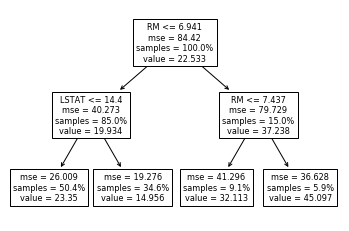

In [12]:
dt = DecisionTreeRegressor(max_depth=2)
model = dt.fit(X, y)
plot_tree(model, feature_names=cols, proportion=True)

<b>General notes on Decision Trees for Regression</b>

<ul>
    <li>Generally, there is no need to use binary trees (i.e we can have three groups instead of two) and no need to select single feature for splitting. However, the approach we used is most widely used and popular.</li>
    <li>In practice, trees experience <b>low bias and very high variance</b> - i.e they tend to overfit. One of the ways to control tree complexity is to limit it's depth or to set the restriction on the minimal number of datapoints required for node to be split further. Usually, ensembling approaches (follow up in this class) are used to lower the variance.</li>
    <li>For <b>nominal categorical variables</b> (i.e ones that can't be ordered) splitting is done by partitioning the set of values for the variable. For example, if we have X={A, B, C} than we can have {A} {B, C} as a split.</li>
</ul>

Refer here, for more notes: https://scikit-learn.org/stable/modules/tree.html

To be continued...

In [19]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import shuffle

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size=0.95)

preds = []
for i in range(100):
    
    X_tr, Y_tr = shuffle(X_train, Y_train)[:100]

    Y_pred = DecisionTreeRegressor(max_depth=10).fit(X_tr, Y_tr).predict(X_test)

    preds.append(Y_pred)
    
    
print('Var:', np.mean((np.array(preds) - np.mean(preds, axis=0))**2))

Var: 0.20231209692307692


### Ensembling

Model ensembling is a technique in Machine Learning to <b>stabilize (reduce variance)</b> of a model's prediction on a unseen samples. It is especially useful with inherently <b>high variance</b> models, such as decision trees.

The idea is to take multiple models trained for the same task and combine their predictions, usually, by averaging or majority voting in case of regression and classification, respectively.

To see why it works (i.e reduces model variance), let's take a look at following fact:

Let's $X_1, X_2, ..., X_n \sim^{iid} X$ and $\bar{X_n}=\frac{1}{n}\sum_{i=1}^n{X_i}$ be a sample average. If $Var(X_i)=\sigma^2$, then $Var(\bar{X_n})=Var(\frac{1}{n}\sum_{i=1}^n{X_i})=\frac{\sigma}n$

This fact can be translated in ML terminology: If we take $N$ "independent" models with some variance and average their predictions, we should get linear decay of variance. By independence we mean models trained on independent samples drawn from underlying data distribution, however, in practice, it's impossible, so we use <b>Cross-Validation</b> to simulate independent samples, or so called <b>Bootstrap Sampling (pseudo-independent sample can be generating by sampling from sample itself, with replacement)</b> that usually works good.</b>

<br />

Alternative intuitive interpretation of <b>single model VS ensemble</b> is to think of it as a decision by single person VS decision by group of people - the latter is more reliable and stable.

<br /><br />

<b><big>Random Forests</big></b>

In practice, we almost always use decision tree ensemble (a.k.a <b>Random Forest</b>) instead of a single tree. Random forest consists of multiple decision trees, usually each trained on bootstrap sample of the train set. Besides, it's common practice select a <b>small random subsample</b> of features for every individual tree, and build those trees on those features. Number of trees in a forest highly varies from task to task, can be 10, 100 or even 1000.

In [15]:
from sklearn.ensemble import RandomForestRegressor

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size=0.95)

preds = []
for i in range(100):
    
    X_tr, Y_tr = shuffle(X_train, Y_train)[:100]

    Y_pred = RandomForestRegressor(max_depth=10, n_estimators=50).fit(X_tr, Y_tr).predict(X_test)

    preds.append(Y_pred)
    
    
print('Var:  ', np.mean((np.array(preds) - np.mean(preds, axis=0))**2))

Var:   0.20069091959478835


<b><big>Boosting</big></b>


In previous section we've seen how to combine multiple models (trained on same data) by averaging or majority voting. That method is usually called <b>Bagging (Bootstrap Aggregating)</b>. As opposed to that, there is a second way of combining models called <b>Boosting</b>. 

As opposed to bagging, where all models do prediction in parallel and then we average the predictions, here we have a prediction pipeline: First model ingests the input data and produces some output which is used as an input to next model in a pipeline to improve output and so on until final model.

In this section we are going to talk about <b>Gradient Tree Boosting</b> - one of the most popular ML methods that uses decision trees as its constituent parts (weak learners)

In this class we will consider $L^2$-Boosting, special (probably easiest to explain) case of Gradient Tree Boosting where the objective is to minimize MSE, i.e a classical regression problem (class attendees are <b>strongly encauraged</b> to view reading material for in other cases of boosting).

Our final predictor for data point $x$, will be of the following form:

$\hat{f}(x)=\alpha_1\hat{f_1}(x)+\alpha_2\hat{f_2}(x)+...+\alpha_n\hat{f_n}(x)$<br /><br />

Where $\alpha_i$ is some real number and $\hat{f_i}$ is a regression tree with fixed size $J$ (number of terminal nodes)

<b>The general intuition is as follows:</b> Each component of the above sum improves on errors (moves towards reduction of error) made by previous component.

The actual algorithm can be defined recursively:
    
1) Let's first just fit a normal regression tree $\hat{f_1}$ on the data and set $\alpha_1$=1. Logically, we have reduces MSE on data by some factor.

2) Now, let's assume we have our trees up to some $m-1$ and wanna add $m$-th tree to our boosting.

$MSE(\hat{f})=\frac{1}{n}\sum_{i=1}^N(y_i - [\alpha_{m-1}\hat{f_{m-1}}(x)+\alpha_m\hat{f_m}(x)])^2$  =  $\frac{1}{n}\sum_{i=1}^N([y_i - \alpha_{m-1}\hat{f_{m-1}}(x)]-\alpha_m\hat{f_m}(x))^2$

<br /><br />From the cost function we can see that $m$-th step is fitting a tree on a residual (target minus prediction) of the previous step (well, residual with alpha term inside).

3) Stop when you have good enough fit (you can check it with cross validation)


(in practice, people usually use small alpha $\alpha=0.1$ (called <b>shrinkage</b>) or use CV to search good alpha)